# 인물사진을 만들어 보자 [프로젝트]

## 프로젝트: 인물 모드 문제점 찾기

In [2]:
# 필요한 라이브러리 불러오기-1
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [3]:
# 필요한 라이브러리 불러오기-2
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


(2736, 2736, 3)


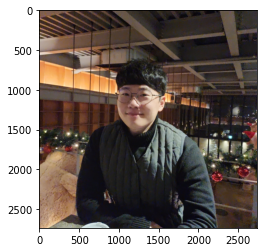

In [4]:
# 준비한 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_all_image.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 셸로우 포커스 만들기

In [5]:
# DeepLab V3+ 모델 불러오기
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 모델 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f6de37883d0>)

In [6]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
# PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 생성
model = semantic_segmentation()
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file)

In [7]:
# segmentAsPascalvoc()함수를 호출하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할은 pacalvoc 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path)

In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

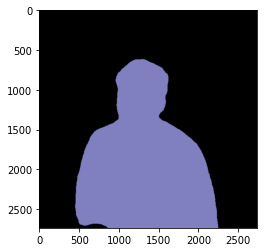

In [9]:
# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [10]:
# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [11]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
colormap[15]

array([192, 128, 128])

In [14]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (128,128,192)

(2736, 2736)


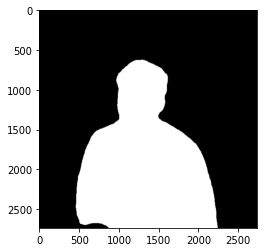

In [15]:
# seg_color로만 이루어진 마스크 생성
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

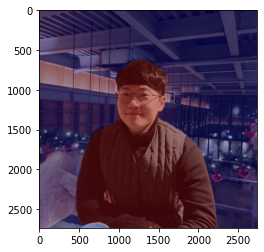

In [16]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

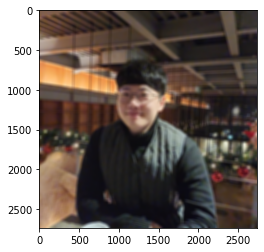

In [51]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (45, 45))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

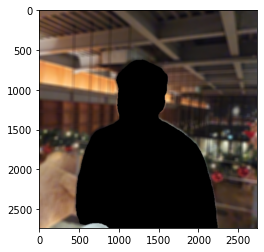

In [52]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

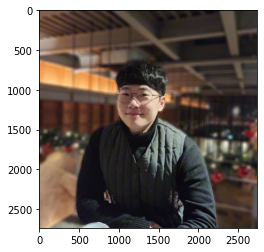

In [53]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 고양이 사진으로 인물모드 해보기

(1400, 1050, 3)


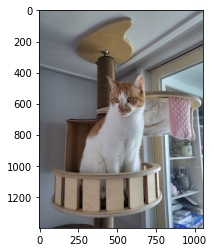

In [20]:
# 준비한 이미지 불러오기
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_cat_image.jpg'  
img_orig_2 = cv2.imread(img_path_2) 

print(img_orig_2.shape)

plt.imshow(cv2.cvtColor(img_orig_2, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
# PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 생성
model_2 = semantic_segmentation()
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model_2.load_pascalvoc_model(model_file)

In [22]:
# segmentAsPascalvoc()함수를 호출하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할은 pacalvoc 데이터로 학습된 모델을 이용
segvalues_2, output_2 = model_2.segmentAsPascalvoc(img_path_2)

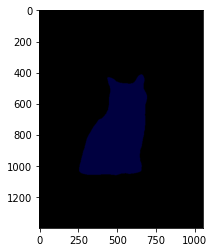

In [23]:
# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output_2)
plt.show()

In [24]:
# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues_2

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [25]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues_2['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [26]:
#컬러맵 8에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 8번째인 고양이)
colormap[8]

array([64,  0,  0])

In [27]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color_2 = (0, 0, 64)

(1400, 1050)


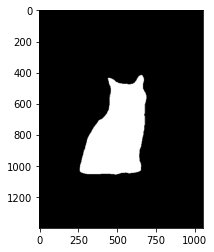

In [28]:
# seg_color로만 이루어진 마스크 생성
seg_map_2 = np.all(output_2==seg_color_2, axis=-1) 
print(seg_map_2.shape) 
plt.imshow(seg_map_2, cmap='gray')
plt.show()

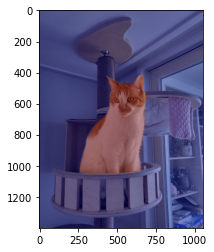

In [29]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show_2 = img_orig_2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_2 = seg_map_2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.show()

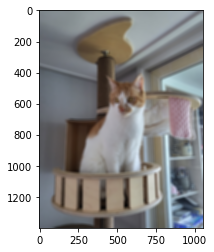

In [30]:
# 배경 흐리게 하기
img_orig_blur_2 = cv2.blur(img_orig_2, (20, 20))

plt.imshow(cv2.cvtColor(img_orig_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

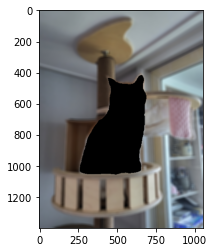

In [31]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color_2 = cv2.cvtColor(img_mask_2, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask_2 = cv2.bitwise_not(img_mask_color_2)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur_2 = cv2.bitwise_and(img_orig_blur_2, img_bg_mask_2)
plt.imshow(cv2.cvtColor(img_bg_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

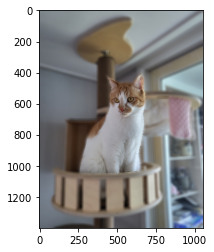

In [32]:
# 흐린 배경과 원본 영상 합성
img_concat_2 = np.where(img_mask_color_2==255, img_orig_2, img_bg_blur_2)

plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.show()

## 배경사진을 다른 이미지로 바꾸기

(638, 850, 3)


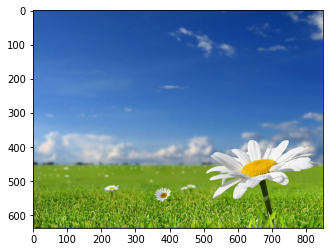

In [33]:
# 새로운 이미지 불러오기
img_new_bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_flower.jpg'  
img_new_bg = cv2.imread(img_new_bg_path) 

print(img_new_bg.shape)

plt.imshow(cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB))
plt.show()

In [38]:
# 원본 이미지 사진 크기 불러오기
height, width = img_orig_2.shape[:2]

print(height)
print(width)

1400
1050


(1400, 1050, 3)


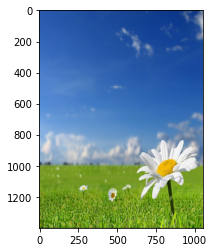

In [40]:
# 새로운 이미지 크기를 원본 이미지 크기에 맞게 조절하기
img_new_bg = cv2.resize(img_new_bg, (width, height))

print(img_new_bg.shape)

plt.imshow(cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB))
plt.show()

In [46]:
# 새로운 배경에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_bg_mask_3 = cv2.bitwise_not(img_mask_color_2)
img_new_bg_masked = cv2.bitwise_and(img_new_bg, img_bg_mask_3)

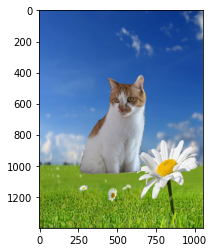

In [47]:
# 새로운 배경과 원본 영상 합성
img_concat_3 = np.where(img_mask_color_2==255, img_orig_2, img_new_bg_masked)

plt.imshow(cv2.cvtColor(img_concat_3, cv2.COLOR_BGR2RGB))
plt.show()

## 이미지 속 문제점 찾기

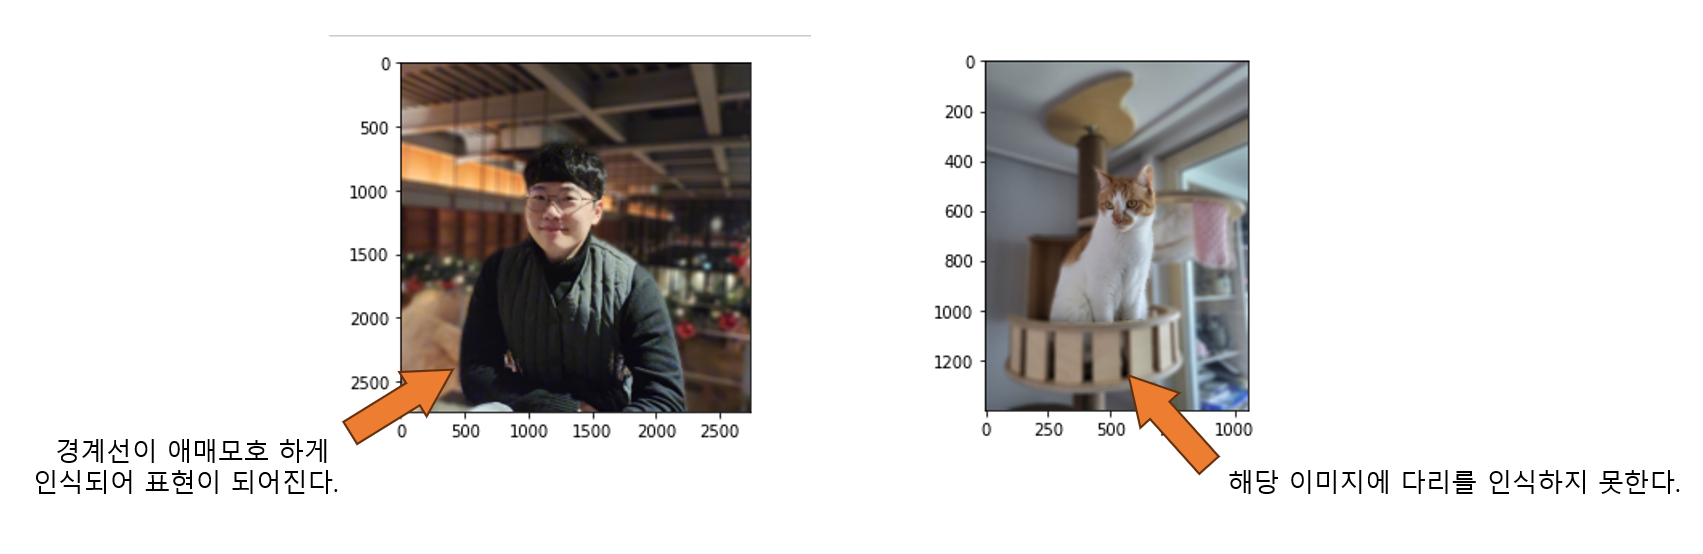

## 인물 모드 사진의 문제점 및 해결방법

인물 및 고양이사진으로 인물 모드 사진을 작업해 본 결과 대체로 인식은 잘 되었다.
하지만 경계선이 애매모호 해지는 점과 이미지속 사진을 제대로 인식을 잘 못하는 점이 있었다.

이러한 문제점을 해결하고자 들어준 예시로 설명을 해보자면   
3D Camera를 이용하여 3차원 이미지를 얻어준다. 이를 통해 배경의 거리를 정확하게 잡아낼 수 있게 된다.

얻어진 3차원 이미지를 비지도 학습 기반의 딥러닝 알고리즘을 활용하여 결합 후 더욱 정확한 인물 모드 사진을 얻을 수 있을거라고 생각이 듭니다.

## 회고
3번째 Exploration 작업을 마무리 하였다. 인물모드 사진을 작업해보면서 신기한점이 많았다. 어느정도 내가 생각한 결과와 비슷하게 나왔지만, 자세히 보다보면 어색한 감이 있었다. 이런 부분들이 어떻게 하면 자연스럽게 나오게 할 수 있을지 해결방법도 궁금하였다.